### Using Tensorflow for object detection and extraction

#### We will implementing transfer learning with ImageAI for custom object detection

In [2]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

# Imports

In [5]:
from imageai.Detection import ObjectDetection

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import xml.etree.ElementTree as xm

from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf

from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Lambda, Input, Reshape
from tensorflow.keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

# Constants

In [3]:
shelf_images = "./GroceryDataset/images/ShelfImages/"
product_images = "./GroceryDataset/images/ProductImagesFromShelves/"


# Trying out the raw model

In [3]:
execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.1.0.h5"))
detector.loadModel()

In [7]:
os.getcwd()

'C:\\Users\\Nikhil\\Desktop\\Hackathon\\Intelligent-Conuter-Share-Analyzer\\ML Models'

In [10]:
os.path.join(execution_path , "resnet50_coco_best_v2.1.0.h5")

'C:\\Users\\Nikhil\\Desktop\\Hackathon\\Intelligent-Conuter-Share-Analyzer\\ML Models\\resnet50_coco_best_v2.1.0.h5'

In [19]:
os.path.join(execution_path , "rect1.png")

'C:\\Users\\Nikhil\\Desktop\\Hackathon\\Intelligent-Conuter-Share-Analyzer\\ML Models\\rect1.png'

In [4]:
detections = detector.detectObjectsFromImage(input_image=os.path.join(execution_path , "Production Assets/Shelf.jpg"), output_image_path=os.path.join(execution_path , "imagenew.jpg"))

for eachObject in detections:
    print(eachObject["name"] , " : " , eachObject["percentage_probability"] )

bottle  :  61.22475266456604
vase  :  56.356436014175415


In [5]:
# import tarfile

# open_tarfile=tarfile.open("GroceryDataset_part1.tar.gz")
# open_tarfile.extractall(path='GroceryDataset_part1')
# open_tarfile.close()

In [6]:
# open_tarfile=tarfile.open("GroceryDataset_part2.tar.gz")
# open_tarfile.extractall(path='GroceryDataset_part2')
# open_tarfile.close()

# Formating the data set in required format

In [12]:
jpg_files = [ f for f in os.listdir(f'{shelf_images}') if f.endswith('JPG') ]
photos_df = pd.DataFrame([[f, f[:6], f[7:14]] for f in jpg_files], columns=['file', 'shelf_id', 'planogram_id'])

In [13]:
print(len(jpg_files))
print(jpg_files[:5])
photos_df.head(5)

354
['C1_P01_N1_S2_1.JPG', 'C1_P01_N1_S2_2.JPG', 'C1_P01_N1_S3_1.JPG', 'C1_P01_N1_S3_2.JPG', 'C1_P01_N1_S5_1.JPG']


,file,shelf_id,planogram_id
0,C1_P01_N1_S2_1.JPG,C1_P01,N1_S2_1
1,C1_P01_N1_S2_2.JPG,C1_P01,N1_S2_2
2,C1_P01_N1_S3_1.JPG,C1_P01,N1_S3_1
3,C1_P01_N1_S3_2.JPG,C1_P01,N1_S3_2
4,C1_P01_N1_S5_1.JPG,C1_P01,N1_S5_1


In [14]:
products_df = pd.DataFrame([[f[:18], f[:6], f[7:14], i, *map(int, f[19:-4].split('_'))]
                           for i in range(11)
                           for f in os.listdir(f'{product_images}{i}') if f.endswith('png')],
                          columns = ['file', 'shelf_id', 'planogram_id', 'category', 'xmin', 'ymin', 'w', 'h'])

# convert from width, height to xmax, ymax

products_df['xmax'] = products_df['xmin'] + products_df['w']
products_df['ymax'] = products_df['ymin'] + products_df['h']

In [15]:
print(products_df.shape)
(products_df.head(5))

(13184, 10)


,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax
0,C1_P01_N1_S2_1.JPG,C1_P01,N1_S2_1,0,1008,1552,252,376,1260,1928
1,C1_P01_N1_S2_1.JPG,C1_P01,N1_S2_1,0,1028,928,252,376,1280,1304
2,C1_P01_N1_S2_1.JPG,C1_P01,N1_S2_1,0,24,872,244,392,268,1264
3,C1_P01_N1_S2_1.JPG,C1_P01,N1_S2_1,0,280,1568,252,376,532,1944
4,C1_P01_N1_S2_1.JPG,C1_P01,N1_S2_1,0,292,872,252,376,544,1248


# converting in pascal VOC format

#### Done in Create Annotation file

# Train with yolov3

In [4]:
from imageai.Detection.Custom import DetectionModelTrainer


In [4]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [3]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
execution_path = os.getcwd()

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory=os.path.join(execution_path ,"GroceryDataset\production"))
trainer.setTrainConfig(object_names_array=["0","1","2","3","4","5","6","7","8","9","10"], batch_size=2, num_experiments=10, train_from_pretrained_model="pretrained-yolov3.h5")
trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.74
Anchor Boxes generated.
Detection configuration saved in  C:\Users\Nikhil\Desktop\Hackathon\Intelligent-Conuter-Share-Analyzer\ML Models\GroceryDataset\production\json\detection_config.json
Evaluating over 50 samples taken from C:\Users\Nikhil\Desktop\Hackathon\Intelligent-Conuter-Share-Analyzer\ML Models\GroceryDataset\production\validation
Training over 100 samples  given at C:\Users\Nikhil\Desktop\Hackathon\Intelligent-Conuter-Share-Analyzer\ML Models\GroceryDataset\production\train
Training on: 	['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
Training with Batch Size:  2
Number of Training Samples:  100
Number of Validation Samples:  50
Number of Experiments:  10
Training with transfer learning from pretrained Model


C:\Users\Nikhil\anaconda3\envs\tf_2\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


C:\Users\Nikhil\anaconda3\envs\tf_2\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/10
  1/400 [..............................] - ETA: 1:49:26 - loss: 133.1132 - yolo_layer_loss: 16.3151 - yolo_layer_1_loss: 27.8740 - yolo_layer_2_loss: 77.3437

# Testing the model

In [4]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("trained models/detection_model-ex-001--loss-0099.677.h5") 
detector.setJsonPath("trained models/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image="GroceryDataset/images/ShelfImages/C1_P01_N1_S3_1.JPG", output_image_path="detected-shelf-image.JPG")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

C:\Users\Nikhil\anaconda3\envs\tf_2\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0  :  72.59123921394348  :  [1174, 1688, 1795, 2217]
0  :  64.21286463737488  :  [1102, 1370, 1601, 2626]
0  :  63.40987682342529  :  [1284, 1527, 1953, 2469]


C:\Users\Nikhil\anaconda3\envs\tf_2\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0  :  58.8617742061615  :  [1569, 174, 2115, 1001]
0  :  50.22878050804138  :  [874, 165, 1569, 1105]
0  :  67.92833209037781  :  [1268, 211, 1879, 1063]
0  :  61.567145586013794  :  [515, 240, 1210, 1118]
0  :  65.38127064704895  :  [1779, 193, 2346, 1164]
0  :  86.40586733818054  :  [653, 1008, 1164, 2428]
2  :  62.969303131103516  :  [653, 1008, 1164, 2428]
4  :  52.91258096694946  :  [653, 1008, 1164, 2428]
4  :  57.59460926055908  :  [909, 1085, 1440, 2355]
4  :  54.27485704421997  :  [1145, 1074, 1647, 2366]
0  :  88.93685340881348  :  [1195, 1093, 1686, 2347]
4  :  56.82775378227234  :  [1400, 1098, 2014, 2344]
0  :  89.18904662132263  :  [860, 1039, 1400, 2482]
2  :  67.0357882976532  :  [860, 1039, 1400, 2482]
2  :  66.38590097427368  :  [1124, 1009, 1669, 2512]
0  :  88.03472518920898  :  [1375, 1042, 1953, 2479]
2  :  63.676267862319946  :  [1375, 1042, 1953, 2479]
0  :  77.75135636329651  :  [1719, 1130, 2315, 2401]
2  :  53.96694540977478  :  [1719, 1130, 2315, 2401]
0  : 

TypeError: Image data of dtype <U42 cannot be converted to float

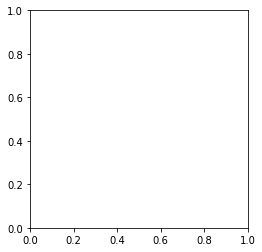

In [6]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("trained models/detection_model-ex-002--loss-0064.244.h5") 
detector.setJsonPath("trained models/detection_config.json")
detector.loadModel()
detections, extracted_images = detector.detectObjectsFromImage(input_image="GroceryDataset/images/ShelfImages/C1_P01_N1_S3_1.JPG", output_image_path="detected-shelf-image_2.JPG",extract_detected_objects=True)
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

# for img in extracted_images:
#     plt.imshow(img)

# Calculating % visibility

In [7]:
dir_path = "detected-shelf-image_2-objects/"

In [10]:
total_objects = len(os.listdir(dir_path))

In [11]:
total_objects

28